In [80]:
import pandas as pd
import ast
from tqdm.notebook import tqdm
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import math
from collections import Counter
from scipy.spatial import distance
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('replies_statistics.pickle', 'rb') as f:
    replies_statistics = pickle.load(f)
replies_statistics

,conversation_id,user_id,username,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,reply_to,...,indegree,outdegree,degree,pageranks,eigencentrality,X,Y,Size,Color,cluster
0,1193730372,15820442,tomwhild,@stephenfry amen Stephen! Vaccination is so im...,['stephenfry'],0,0,0,[],"[{'user_id': '15820442', 'username': 'tomwhild...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1193730372,2276201,sevitz,http://tinyurl.com/btokam Vaccination scares a...,['stephenfry'],0,0,0,[],"[{'user_id': '2276201', 'username': 'sevitz'},...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1193730372,12488312,elbisivni,this chap needs our support http://tinyurl.co...,['stephenfry'],0,0,0,[],"[{'user_id': '12488312', 'username': 'elbisivn...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1193730372,7461972,atariageguy,"@stephenfry Yes, this is infuriating. Especia...",['stephenfry'],0,0,0,[],"[{'user_id': '7461972', 'username': 'atariageg...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1193730372,15022458,weaselbacon,@stephenfry Thanks for that. Vaccination is on...,['stephenfry'],0,0,0,[],"[{'user_id': '15022458', 'username': 'weaselba...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351123,964000000000000000,766000000000000000,pancaraccia,Le virus de la variole se transmet exclusiveme...,['malacella2b'],0,0,0,[],"[{'user_id': '765943276377628673', 'username':...",...,0.0,19.0,19.0,0.000003,0.000000,1825.054443,-1056.008911,10.0,#000000,29.0
1351124,941000000000000000,849805975,realchaim_rubin,. Calling it mutilation is not convincing Just...,"['rockerman_198', 'huiecaleb', 'peppi1207', 'r...",5,0,0,[],"[{'user_id': '849805975', 'username': 'realCha...",...,1.0,53.0,54.0,0.000003,0.000543,1915.292847,-2043.280762,10.0,#000000,41.0
1351125,961000000000000000,743000000000000000,suraiyahuss,In 1796 the English doctor Edward Jenner devel...,"['zuk60', 'hamedomaribrah3', 'saranoo14119598'...",1,0,2,[],"[{'user_id': '742765890735869954', 'username':...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1351126,941000000000000000,976000000000000000,dkingpower7,No. Circumcision is nothing like vaccination. ...,"['realchaim_rubin', 'genintact', 'scriptelador...",0,0,0,[],"[{'user_id': '976478598117851136', 'username':...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
clusters = [6, 18, 19, 21, 28, 35]
replies_clusters = replies_statistics[~replies_statistics['Id'].isna()].query(
    'cluster in @clusters'
).reset_index(drop=True)

replies_vectors = np.array([i for i in replies_clusters['embeddings'].values])

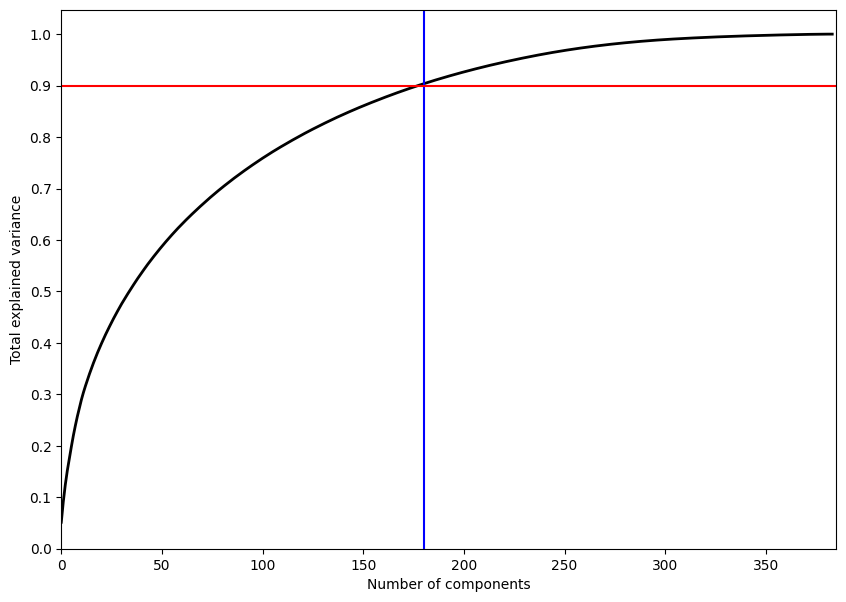

In [47]:
pca = PCA().fit(replies_vectors)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 385)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(180, c = 'b')
plt.axhline(0.9, c = 'r')
plt.show()

In [48]:
replies_vectors_pca = PCA(n_components = 180).fit_transform(replies_vectors)
replies_vectors_pca

array([[ 0.13828461,  0.00270429, -0.1409345 , ...,  0.01499625,
         0.00982623,  0.00436869],
       [-0.04849705, -0.08314731,  0.08168119, ..., -0.00476039,
        -0.00462966,  0.00850664],
       [-0.13314146, -0.13254921, -0.10493028, ..., -0.00403043,
         0.01340518,  0.02586771],
       ...,
       [-0.10128932, -0.0425625 ,  0.09629771, ..., -0.04194146,
         0.06699382,  0.02439891],
       [ 0.5511284 ,  0.18479885,  0.01498145, ..., -0.02918549,
        -0.02416911,  0.02731207],
       [-0.11454093,  0.06595814, -0.04639497, ...,  0.01168116,
         0.02069176, -0.01982743]], dtype=float32)

In [81]:
tsne = TSNE(n_components=2, perplexity=40)
tsne.fit(replies_vectors_pca)
newZ = tsne.embedding_

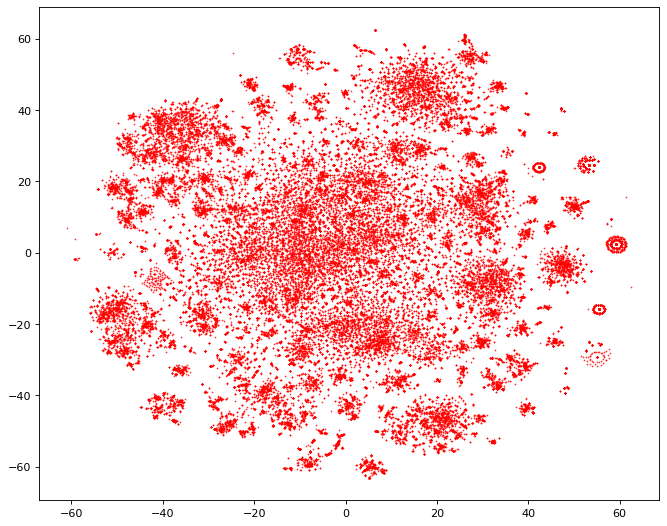

In [55]:
figure(figsize=(10, 8), dpi=80)
plt.scatter(newZ[:, 0], newZ[:, 1], c='r', s=0.2)
plt.show()

In [63]:
replies_clusters['embeddings_pca'] = None
replies_clusters['embeddings_tsne'] = None
for i in tqdm(replies_clusters.index):
    replies_clusters['embeddings_pca'][i] = replies_vectors_pca[i]
    replies_clusters['embeddings_tsne'][i] = newZ[i]

  0%|          | 0/51300 [00:00<?, ?it/s]

In [65]:
with open('replies_clusters.pickle', 'wb') as f:
    pickle.dump(replies_clusters, f)

In [116]:
def make_avg_vector(embeddings):
    vector_len = len(embeddings[0])
    avg_vector = [0]*vector_len
    for v_i in embeddings:
        for j in range(vector_len):
            avg_vector[j] += v_i[j]
    rms = 0
    for j in range(vector_len):
        rms = rms + avg_vector[j] * avg_vector[j]
    rms = math.sqrt(rms / vector_len)

    for j in range(vector_len):
        avg_vector[j] = avg_vector[j] / rms

    return np.array(avg_vector)

In [117]:
users_embeddings = pd.DataFrame(replies_clusters['user_id'].unique(), columns=['user_id'])
users_embeddings['avg_embedding_pca'] = None

for i, user_id in enumerate(users_embeddings['user_id']):
    user_tweets = replies_clusters.query('user_id == @user_id')['embeddings_pca'].values
    avg_vector = make_avg_vector(user_tweets)
    users_embeddings['avg_embedding_pca'][i] = avg_vector

In [124]:
users_vectors_pca = np.array([i for i in users_embeddings['avg_embedding_pca'].values])
tsne_users = TSNE(n_components=2, perplexity=40)
tsne_users.fit(users_vectors_pca)
newZ_users = tsne_users.embedding_

users_embeddings['avg_embedding_tsne'] = None
for i in users_embeddings.index:
    users_embeddings['avg_embedding_tsne'][i] = newZ_users[i]

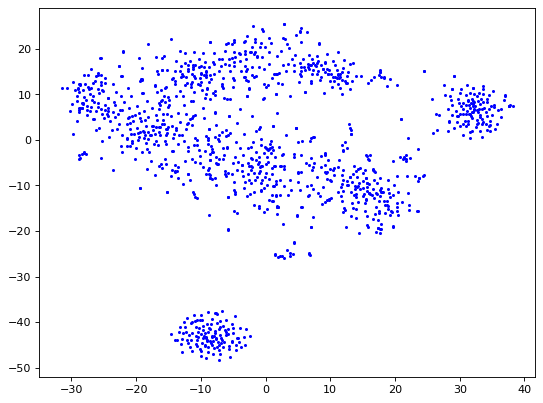

In [125]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(newZ_users[:, 0], newZ_users[:, 1], c='b', s=3)
plt.show()

In [126]:
cluster_model = AgglomerativeClustering(n_clusters=6).fit(users_vectors_pca)
users_embeddings['tweets_cluster'] = cluster_model.labels_

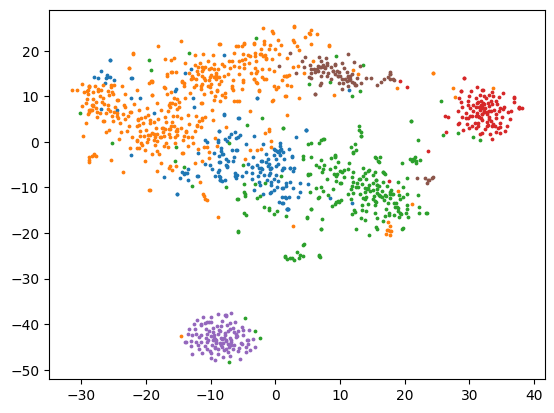

In [128]:
for cluster in users_embeddings['tweets_cluster'].unique():
    users_cluster = np.array([i for i in users_embeddings
                             .query('tweets_cluster == @cluster')['avg_embedding_tsne'].values])
    plt.scatter(users_cluster[:, 0], users_cluster[:, 1], s=3)

In [129]:
users_embeddings

,user_id,avg_embedding_pca,avg_embedding_tsne,tweets_cluster
0,23249874,"[-1.4457121343056945, -2.726949151588105, -1.1...","[-5.6447105, 5.30092]",2
1,16854311,"[-4.039205190879364, -5.223082010922813, -2.25...","[-12.493938, 12.146298]",0
2,11274452,"[-3.0484772219835867, -5.323914247520286, -1.6...","[-5.688768, 5.2255354]",2
3,17054920,"[-1.1668776969896004, -2.607213889241218, 3.44...","[0.34754875, 12.012313]",0
4,67735456,"[-0.8337440585171392, 0.8233614155332241, -0.1...","[1.9250319, -14.756243]",2
...,...,...,...,...
1238,75331717,"[2.0630409902511833, -0.5900079844391538, -1.9...","[-18.18363, 21.018745]",0
1239,254909054,"[7.659481089528668, 2.4995780893554618, 2.0724...","[19.211359, 13.4498415]",3
1240,273897097,"[-0.8354910789813949, 1.5536270709366207, 1.15...","[1.8312898, 5.9252806]",0
1241,16481548,"[-2.1440695149008318, -1.9036885668248171, -1....","[-17.116072, 12.048333]",0


In [131]:
replies_clusters = replies_clusters.merge(users_embeddings, on='user_id', how='left')

with open('replies_clusters.pickle', 'wb') as f:
    pickle.dump(replies_clusters, f)